$ \newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|} $
$\newcommand{\au}{\hat{a}^\dagger}$
$\newcommand{\ad}{\hat{a}}$
$\newcommand{\bu}{\hat{b}^\dagger}$
$\newcommand{\bd}{\hat{b}}$
# Cat state encoding
The main goal is to find control pulses which will realise the state transfer:
$$ \underbrace{(c_0\ket{0} + c_1\ket{1})}_{\text{Qubit}}\underbrace{\ket{0}}_{\text{Cavity}} \rightarrow \ket{0}(c_0\ket{C_0} + c_1 \ket{C_1}) $$
where $ \ket{C_0} \propto \ket{-\alpha} + \ket{\alpha} $ is the logical zero and $ \ket{C_1} \propto \ket{-i\alpha} + \ket{i\alpha} $ is the logical one. The method is to optimise such that the six cardinal points on the Bloch sphere realise these cavity cat states and puts the qubit to the ground state.

In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
from matplotlib import animation, rc
from IPython.display import HTML

In [58]:
from qutip import *
#from qutip import identity, sigmax, sigmay, sigmaz, sigmam, sigmap, tensor, projection, create, destroy, displace
#from qutip import Qobj, basis, coherent, mesolve, fock
#from qutip import expect
from qutip.superoperator import liouvillian, sprepost
from qutip.qip import hadamard_transform
from qutip.visualization import plot_wigner, plot_wigner_fock_distribution
from qutip.ipynbtools import plot_animation
import qutip.logging_utils as logging
#from qutip import Bloch
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.WARN
#log_level = logging.WARN
#QuTiP control modules
import qutip.control.pulseoptim as cpo
from numpy import pi, sqrt
file_name = 'Test1'

In [59]:
from time import time

def printTime(start):
    end = time()
    duration = end - start
    if duration < 60:
        return "used: " + str(round(duration, 2)) + "s."
    else:
        mins = int(duration / 60)
        secs = round(duration % 60, 2)
        if mins < 60:
            return "used: " + str(mins) + "m " + str(secs) + "s."
        else:
            hours = int(duration / 3600)
            mins = mins % 60
            return "used: " + str(hours) + "h " + str(mins) + "m " + str(secs) + "s."


# Physics
## Hamiltonian
$$ \hat{H} =  \underbrace{(\omega_a - \chi_{sa}\au\ad)\bu\bd}_{\text{Storage-ancilla coupling}} +\, \omega_s\au\ad  \,-\, \frac{K_s}{2}\au{}^2\ad{}^2 \,-\, \frac{K_a}{2}\bu{}^2\bd{}^2 \,+\, \underbrace{\epsilon_a(t)\bu + \epsilon_a^*(t)\bd}_{\text{Qubit drive}} \,+\, \underbrace{\epsilon_s(t)\au + \epsilon_s^*(t)\ad}_{\text{Res drive}} $$

$$ \bu\bd = \ket{1}\bra{1} = \sigma_-\sigma_+ $$

In [336]:
N = 3
b = destroy(N)
Sx = identity(N).full()
Sx[0:N-1,0:N-1] = sigmax().full()
Sx = Qobj(Sx)

def hamiltonian(w_ge, alpha):
    H0 = w_ge/2.0 * b.dag()*b + alpha/2.0 * b.dag()**2 * b**2
    return H0

w_ge = 2*pi
alpha = -0.03226
H = hamiltonian(w_ge, alpha)

# System check
Some tests to see if the system is setup correctly

In [337]:
check_systems = True

In [377]:
1/9*(b + b.dag())**5*basis(N,0)

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]]

# Energy spectrum

E2 is -0.03225999999999907 than the harmonic level


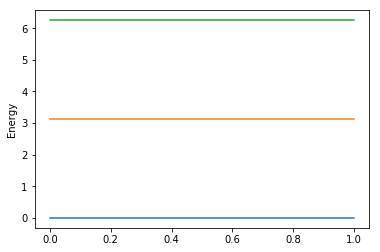

In [338]:
x = [0, 1]
E = H.eigenenergies()
for e in E:
    plt.plot(x,[e, e])
    plt.ylabel('Energy')
print("E2 is {} than the harmonic level".format(E[2]-2*E[1]+E[0]))

## Time evolution of pulse

In [402]:
def pulse_verification(H0, ctrls, psi0, uks, gate_time):
    Hops = ctrls
    gate_steps = len(uks)

    # H0 and Hops
    H0_qobj = H0
    Hops_qobj = ctrls

    # define time    
    tlist = np.linspace(0,gate_time,gate_steps+1)
    dt = gate_time/gate_steps
    
    # append zero control pulse at the end of uks (final timestep)
    uks_t0 = np.zeros((uks.shape[0],1))
    uks = np.hstack([uks,uks_t0])

    # looping over each initial vector
    for init_vector_id in range(len(initial_vectors_c)):

        # initial vector
        psi0 = qt.Qobj(initial_vectors_c[init_vector_id])

        # make functions to return uks field
        def make_get_uks_func(id):
            def _function(t,args=None):
                time_id = int(t/dt)
                return uks[id][time_id]
            return _function

        # create the time-dependent Hamiltonian list
        Ht_list = []
        Ht_list.append(H0_qobj)
        for ii in range(len(Hops)):
            Ht_list.append([Hops_qobj[ii],make_get_uks_func(ii)])

        # solving the Schrodinger evolution in QuTiP's sesolve
        output = qt.sesolve(Ht_list, psi0, tlist, [])

        # obtaining the simulation result
        state_tlist = []
        for state in output.states:
            state_tlist.append(state.full())
        state_tlist = np.array(state_tlist)[:,:,0]
        state_tlist = np.transpose(state_tlist)


        # absolute difference of simulation result from Tensorflow and QuTiP
        abs_diff = np.abs(state_tlist) - np.abs(inter_vecs_raw[init_vector_id])        
        max_abs_diff_list.append(np.max(abs_diff))

        # if all close between simulation result from Tensorflow and QuTiP
        all_close = np.allclose(state_tlist,inter_vecs_raw[init_vector_id],atol=atol)        
        all_close_list.append(all_close)

    print("QuTiP simulation verification result for each initial state")
    print("================================================")
    print("max abs diff: " + str(max_abs_diff_list))
    print("all close: " + str(all_close_list))
    print("================================================")

10.0%. Run time:   0.10s. Est. time left: 00:00:00:00
20.0%. Run time:   0.19s. Est. time left: 00:00:00:00
30.0%. Run time:   0.28s. Est. time left: 00:00:00:00
40.0%. Run time:   0.36s. Est. time left: 00:00:00:00
50.0%. Run time:   0.45s. Est. time left: 00:00:00:00
60.0%. Run time:   0.54s. Est. time left: 00:00:00:00
70.0%. Run time:   0.63s. Est. time left: 00:00:00:00
80.0%. Run time:   0.72s. Est. time left: 00:00:00:00
90.0%. Run time:   0.80s. Est. time left: 00:00:00:00
Total run time:   0.88s


### Expectation values

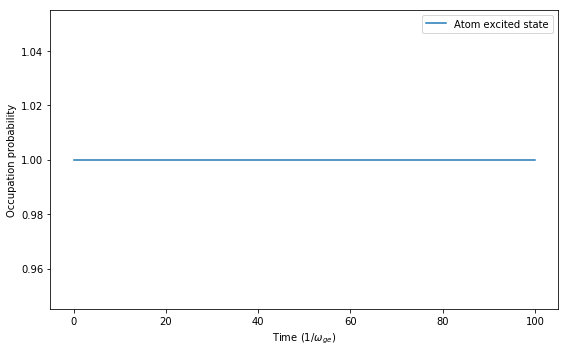

In [403]:
if check_systems:
    nq_list = expect(b.dag()*b, res.states)
    fig, ax = plt.subplots(sharex=True,figsize=(8,5))
    ax.plot(tlist, nq_list, label="Atom excited state")
    ax.legend()
    ax.set_xlabel('Time (1/$\\omega_{ge}$)')
    ax.set_ylabel('Occupation probability');
    fig.tight_layout()

In [401]:
def plot_states(states, is_qubit = False):
    f = plt.figure(figsize=(6*len(states), 6));
    for i, state in enumerate(states):
        if is_qubit:
            ax = f.add_subplot(1,len(states),i+1, projection='3d')
            bl = Bloch(fig=f, axes=ax)
            bl.add_states(state)
            bl.render(fig=f, axes=ax);
            #bl.show()
        else:
            plot_wigner_fock_distribution(state);
    f.show();

In [435]:
# Time allowed for the evolution
evo_time = 4
# Number of time slots
n_ts = 50

In [436]:
# Fidelity error target
fid_err_targ = 1e-8
# Maximum iterations for the optisation algorithm
max_iter = 1000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 60*1
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'RND'
#Set to None to suppress output files
#f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)
f_ext = None

In [437]:
phi = basis(N,0)
phi_targ = basis(N,1)
print("Initial fidelity: {}".format(fidelity((phi),(phi_targ))))

ctrls = [b.dag()]

result = cpo.optimize_pulse(H, ctrls, phi, phi_targ, n_ts, evo_time, 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                out_file_ext=f_ext, init_pulse_type=p_type, 
                log_level=log_level, gen_stats=True,
                            amp_ubound = 1,amp_lbound = -1,
                fid_params={'phase_option':'SU'},
                fid_type='TRACEDIFF',)
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(datetime.timedelta(seconds=result.wall_time)))

Initial fidelity: 0.0

------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:24.121677
Wall time computing Hamiltonians: 0:00:00.400375 (1.66%)
Wall time computing propagators: 0:00:21.451418 (88.93%)
Wall time computing forward propagation: 0:00:00.133883 (0.56%)
Wall time computing onward propagation: 0:00:00.160595 (0.67%)
Wall time computing gradient: 0:00:01.431517 (5.93%)

**** Iterations and function calls ****
Number of iterations: 1000
Number of fidelity function calls: 1340
Number of times fidelity is computed: 1340
Number of gradient function calls: 1340
Number of times gradients are computed: 1340
Number of times timeslot evolution is recomputed: 1340

**** Control amplitudes ****
Number of control amplitude updates: 1339
Mean number of updates per iteration: 1.339
Number of timeslot values changed: 66533
Mean number of timeslot changes per update: 49.68857356235997
Number 

<Figure size 1296x432 with 0 Axes>

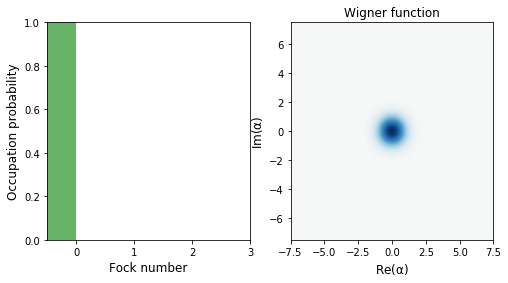

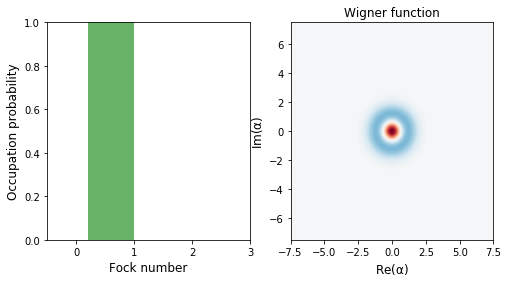

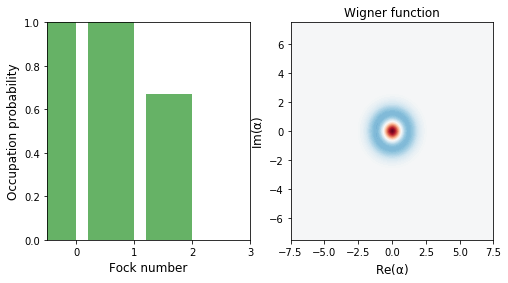

In [438]:
states = [phi, phi_targ, result.evo_full_final]
#qubit_states = [s.ptrace(0) for s in states]
#res_states = [s.ptrace(1) for s in states]
#plot_states(states, True)
plot_states(states)

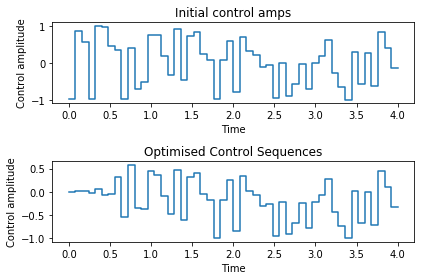

In [439]:
def plot_control_pulses(result):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(2, 1, 1)
    ax1.set_title("Initial control amps")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Control amplitude")
    ax2 = fig1.add_subplot(2, 1, 2)
    ax2.set_title("Optimised Control Sequences")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Control amplitude")
    for i in range(len(ctrls)):
        ax1.step(result.time, 
                 np.hstack((result.initial_amps[:, i], result.initial_amps[-1, i])), 
                 where='post')
        ax2.step(result.time, 
         np.hstack((result.final_amps[:, i], result.final_amps[-1, i])), 
         where='post')
    fig1.tight_layout()
    
plot_control_pulses(result)